In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
%matplotlib inline
import plotly.express as px
from collections import Counter

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/jieba/_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score

In [3]:
text = "我今天喝了一杯好喝的咖啡。"
seg = jieba.lcut(text)
print(seg)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/l0/spz2n66d4klcgyvq68wdl0pw0000gn/T/jieba.cache
Loading model cost 0.229 seconds.
Prefix dict has been built successfully.


['我', '今天', '喝', '了', '一杯', '好喝', '的', '咖啡', '。']


In [4]:
train = pd.read_csv("../Datasets/ChineseDatasets/online_shopping_10_cats.csv")
test = pd.read_csv("../Datasets/ChineseDatasets/waimai_10k.csv")
test_ex = pd.read_csv("../Datasets/ChineseDatasets/CH_test_dataset.csv")

In [5]:
print(train.shape)
print(test.shape)
print(test_ex.shape)

(62774, 3)
(11987, 2)
(219, 2)


In [6]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62773 entries, 0 to 62773
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     62773 non-null  object
 1   label   62773 non-null  int64 
 2   review  62773 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987 entries, 0 to 11986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11987 non-null  int64 
 1   review  11987 non-null  object
dtypes: int64(1), object(1)
memory usage: 187.4+ KB


In [7]:
train.head()
test.head()
test_ex.head()

,label,content
0,1,虽然有震动，但声音比几年前的产品小一些，应该是想办法改进了，有几个瞬间有集聚的能量集中爆发，...
1,1,包装完好无破损无异味，豆浆机外观漂亮大气，打的豆浆细腻无渣，口感顺滑。大品牌质量有保障。
2,1,实物比图片还好看，放在厨房特别有格调。最意外的是工作时的噪音，早上用完全不会吵醒家人。打出来...
3,1,该用户觉得商品非常好，给出5星好评
4,1,收到就洗干净用来打了花生浆，用新鲜的七彩花生和银耳来打的，打好后加适量糖，口感丝滑细腻，无渣...


<Axes: xlabel='label', ylabel='count'>

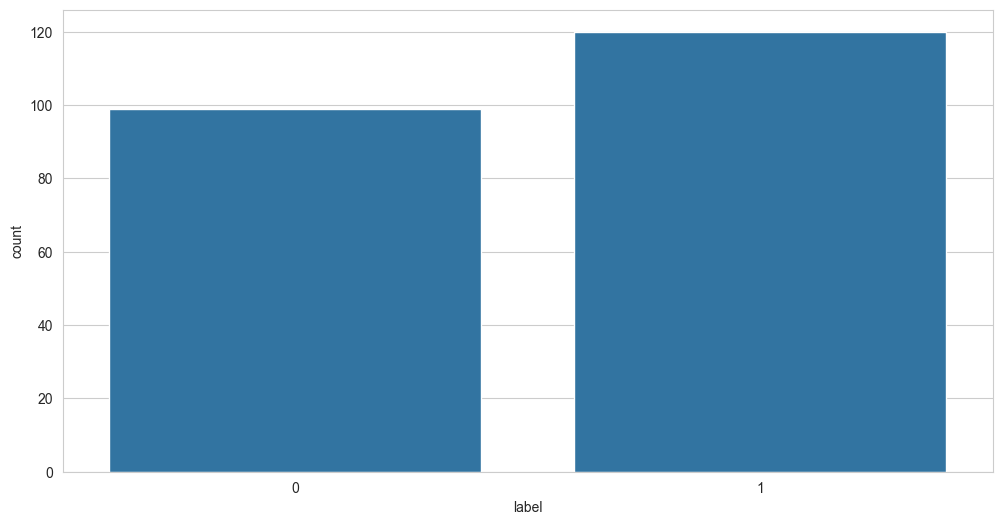

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=test_ex)

<Axes: xlabel='label', ylabel='count'>

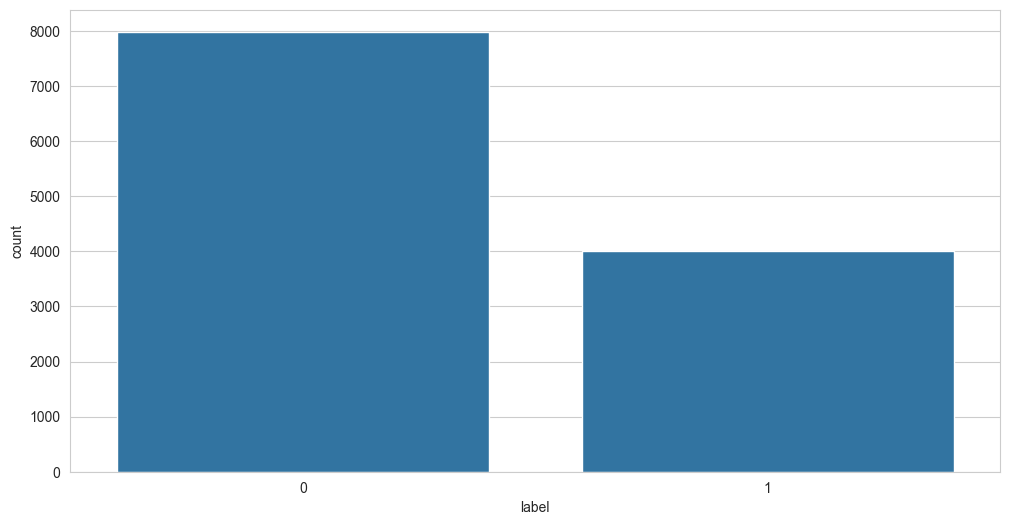

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=test)

In [10]:
def clean_zh(text):
    text = str(text)
    text = text.strip()
    text = re.sub(r'https?://\S+|www\.\S+|\S+\.\S+/\S+', '', text)
    text = re.sub(r'@[^\s]+', ' ', text)
    text = re.sub(r'[^\u4e00-\u9fa5]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)
    return text

In [11]:
train['review'] = train['review'].apply(lambda x: clean_zh(x))
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62773 entries, 0 to 62773
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cat     62773 non-null  object
 1   label   62773 non-null  int64 
 2   review  62773 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.9+ MB


In [12]:
train.head()

,cat,label,review
0,书籍,1,做父母一定要有刘墉这样的心态 不断地学习 不断地进步 不断地给自己补充新鲜血液 让自己保持一...
1,书籍,1,作者真有英国人严谨的风格 提出观点 进行论述论证 尽管本人对物理学了解不深 但是仍然能感受到...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点 为什么荷兰曾经县有欧洲最高的生产...
3,书籍,1,作者在战几时之前用了 拥抱 令人叫绝 日本如果没有战败 就有会有美军的占领 没胡官僚主义的延...
4,书籍,1,作者在少年时即喜阅读 能看出他精读了无数经典 因而他有一个庞大的内心世界 他的作品最难能可贵...


In [13]:
test['review'] = test['review'].apply(lambda x: clean_zh(x))
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11987 entries, 0 to 11986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11987 non-null  int64 
 1   review  11987 non-null  object
dtypes: int64(1), object(1)
memory usage: 187.4+ KB


In [14]:
test_ex['content'] = test_ex['content'].apply(lambda x: clean_zh(x))

In [15]:
test_ex.head()

,label,content
0,1,虽然有震动 但声音比几年前的产品小一些 应该是想办法改进了 有几个瞬间有集聚的能量集中爆发 ...
1,1,包装完好无破损无异味 豆浆机外观漂亮大气 打的豆浆细腻无渣 口感顺滑 大品牌质量有保障
2,1,实物比图片还好看 放在厨房特别有格调 最意外的是工作时的噪音 早上用完全不会吵醒家人 打出来...
3,1,该用户觉得商品非常好 给出 星好评
4,1,收到就洗干净用来打了花生浆 用新鲜的七彩花生和银耳来打的 打好后加适量糖 口感丝滑细腻 无渣...


In [16]:
def jieba_tokenizer(text):
    return jieba.lcut(text)

In [17]:
# Tokenizer
train['temp_list'] = train['review'].apply(jieba_tokenizer)

top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,,370558
1,的,114826
2,了,57088
3,很,30275
4,是,29071
5,我,24644
6,也,20882
7,好,19170
8,不,18549
9,都,17012


In [18]:
# Stop words
with open("../Datasets/ChineseDatasets/Stop_words/cn_stopwords.txt", 'r', encoding="utf-8") as f:
    stop_words = [w.strip() for w in f]

In [19]:
def remove_stopwords(tokens):
    return [w for w in tokens if w not in stop_words and w.strip() != ""]

In [20]:
train['temp_list'] = train['temp_list'].apply(lambda x: remove_stopwords(x))
train.head()

,cat,label,review,temp_list
0,书籍,1,做父母一定要有刘墉这样的心态 不断地学习 不断地进步 不断地给自己补充新鲜血液 让自己保持一...,"[做, 父母, 一定, 刘墉, 心态, 不断, 学习, 不断, 进步, 不断, 补充, 新鲜..."
1,书籍,1,作者真有英国人严谨的风格 提出观点 进行论述论证 尽管本人对物理学了解不深 但是仍然能感受到...,"[作者, 真有, 英国人, 严谨, 风格, 提出, 观点, 进行, 论述, 论证, 物理学,..."
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点 为什么荷兰曾经县有欧洲最高的生产...,"[作者, 长篇大论, 借用, 详细, 报告, 数据处理, 工作, 计算结果, 支持, 其新,..."
3,书籍,1,作者在战几时之前用了 拥抱 令人叫绝 日本如果没有战败 就有会有美军的占领 没胡官僚主义的延...,"[作者, 战, 之前, 拥抱, 令人, 叫绝, 日本, 没有, 战败, 会, 美军, 占领,..."
4,书籍,1,作者在少年时即喜阅读 能看出他精读了无数经典 因而他有一个庞大的内心世界 他的作品最难能可贵...,"[作者, 少年, 时即, 喜, 阅读, 看出, 精读, 无数, 经典, 一个, 庞大, 内心..."


In [21]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,买,15498
1,不错,15341
2,没有,11563
3,酒店,11106
4,京东,8750
5,说,7995
6,房间,7952
7,非常,6468
8,一个,6461
9,感觉,6362


In [22]:
Positive_set = train[train['label'] == 1]
Negative_set = train[train['label'] == 0]

In [23]:
top = Counter([item for sublist in Positive_set['temp_list'] for item in sublist])
# the most common words in different sentiments
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive = temp_positive.iloc[1:,:]
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
1,买,7285
2,酒店,5921
3,非常,4746
4,没有,4312
5,京东,4267
6,房间,4000
7,喜欢,3928
8,感觉,3850
9,比较,3675
10,质量,3443


In [24]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [25]:
top = Counter([item for sublist in Negative_set['temp_list'] for item in sublist])
# the most common words in different sentiments
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_positive.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Greens')

,Common_words,count
2,酒店,5921
3,非常,4746
4,没有,4312
5,京东,4267
6,房间,4000
7,喜欢,3928
8,感觉,3850
9,比较,3675
10,质量,3443
11,服务,3081


In [26]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [27]:
train['temp_list'] = train['temp_list'].apply(lambda x: " ".join(x))
X = train['review']
y = train['label']

external_test_x = test['review']
external_test_y = test['label']

extra_test_x = test_ex['content']
extra_test_y = test_ex['label']

train_x, test_x, train_y, test_y = model_selection.train_test_split(X, y, test_size = 0.20, shuffle = True, random_state = 42)

In [28]:
nb_model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
    ('clf', MultinomialNB()),
])

nb_model.fit(train_x, train_y)
nb_pred = nb_model.predict(test_x)

external_nb_pred = nb_model.predict(external_test_x)
extra_nb_pred = nb_model.predict(extra_test_x)

print("Naive Bayes Accuracy:", accuracy_score(nb_pred, test_y))
print("External Naive Bayes Accuracy:", accuracy_score(extra_nb_pred, extra_test_y))

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Naive Bayes Accuracy: 0.9059338908801274
External Naive Bayes Accuracy: 0.8401826484018264


<Figure size 600x500 with 0 Axes>

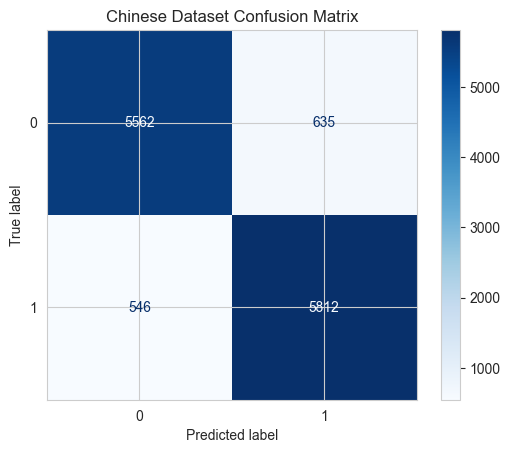

In [29]:
labels = [0, 1]
cm = confusion_matrix(test_y, nb_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Chinese Dataset Confusion Matrix")
plt.show()

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent wi

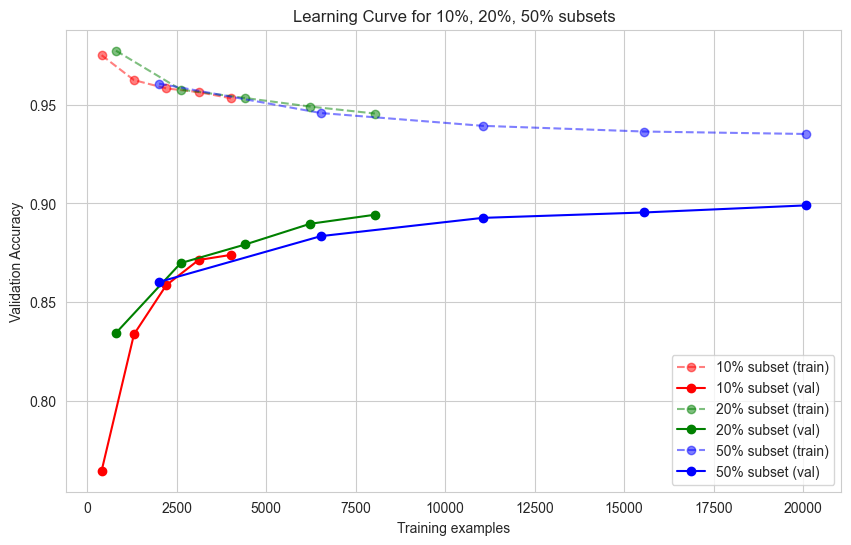

In [58]:
# divide training set to 10%,20%,50%
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curve for 10%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("Ch_NB_LearningCurves.pdf", bbox_inches='tight')
plt.show()

In [31]:
lr_model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
    ('clf', LogisticRegression(max_iter=1000))
])

lr_model.fit(train_x, train_y)
lr_pred = lr_model.predict(test_x)

external_lr_pred = lr_model.predict(external_test_x)
extra_lr_pred = lr_model.predict(extra_test_x)

print("Logistic Regression Accuracy:", accuracy_score(lr_pred, test_y))
print("External Logistic Regression Accuracy:", accuracy_score(extra_lr_pred, extra_test_y))

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Logistic Regression Accuracy: 0.9100756670649144
External Logistic Regression Accuracy: 0.8310502283105022


<Figure size 600x500 with 0 Axes>

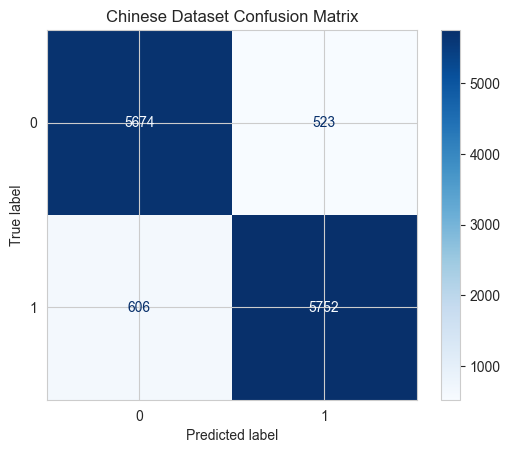

In [32]:
labels = [0, 1]
cm = confusion_matrix(test_y, lr_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Chinese Dataset Confusion Matrix")
plt.show()

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not

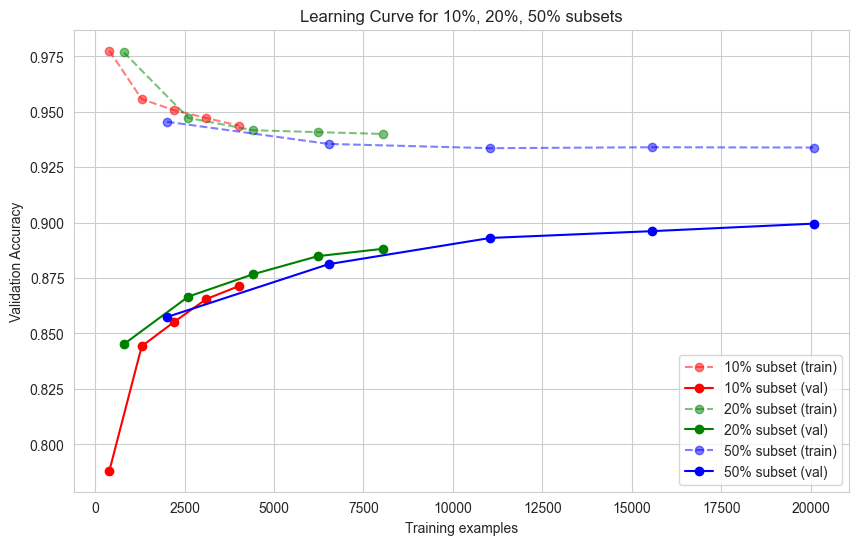

In [33]:
# divide training set to 10%,20%,50%
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curve for 10%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("Ch_LR_LearningCurves.pdf", bbox_inches='tight')
plt.show()

In [34]:
svm_model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
    ('clf', LinearSVC(max_iter=1000))
])

svm_model.fit(train_x, train_y)
svm_pred = svm_model.predict(test_x)

external_svm_pred = svm_model.predict(external_test_x)
extra_svm_pred = svm_model.predict(extra_test_x)

print("Linear SVM Accuracy:", accuracy_score(svm_pred, test_y))
print("External SVM Accuracy:", accuracy_score(extra_svm_pred, extra_test_y))

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Linear SVM Accuracy: 0.9115890083632019
External SVM Accuracy: 0.8447488584474886


<Figure size 600x500 with 0 Axes>

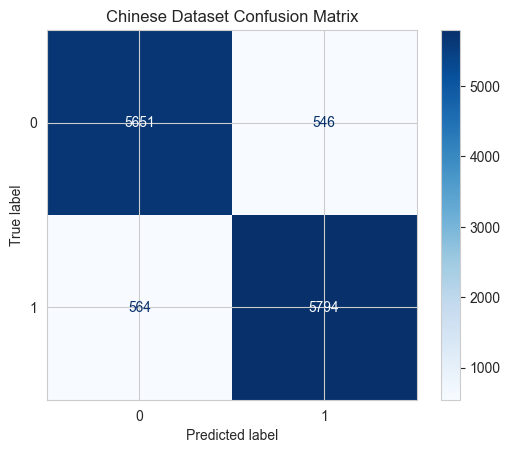

In [35]:
labels = [0, 1]
cm = confusion_matrix(test_y, svm_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Chinese Dataset Confusion Matrix")
plt.show()

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent wi

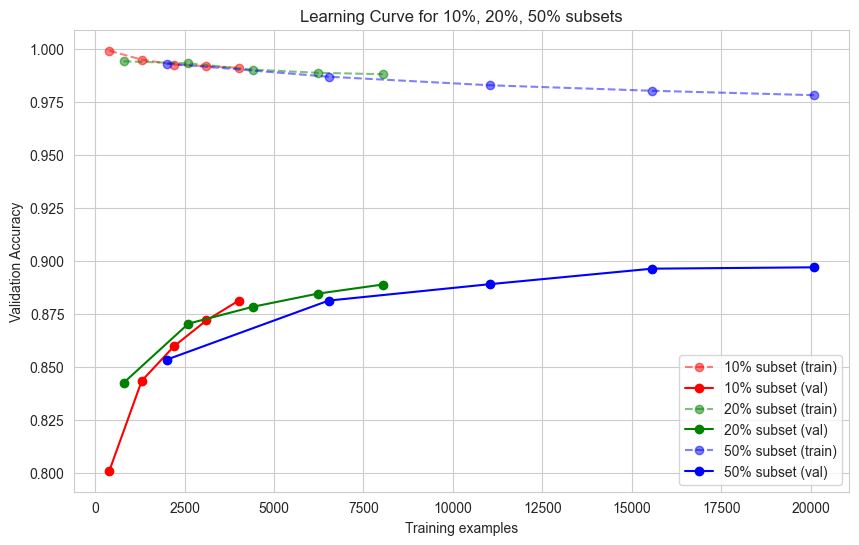

In [36]:
# divide training set to 10%,20%,50%
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', LinearSVC(max_iter=1000))
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curve for 10%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("Ch_SVM_LearningCurves.pdf", bbox_inches='tight')
plt.show()

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent wi

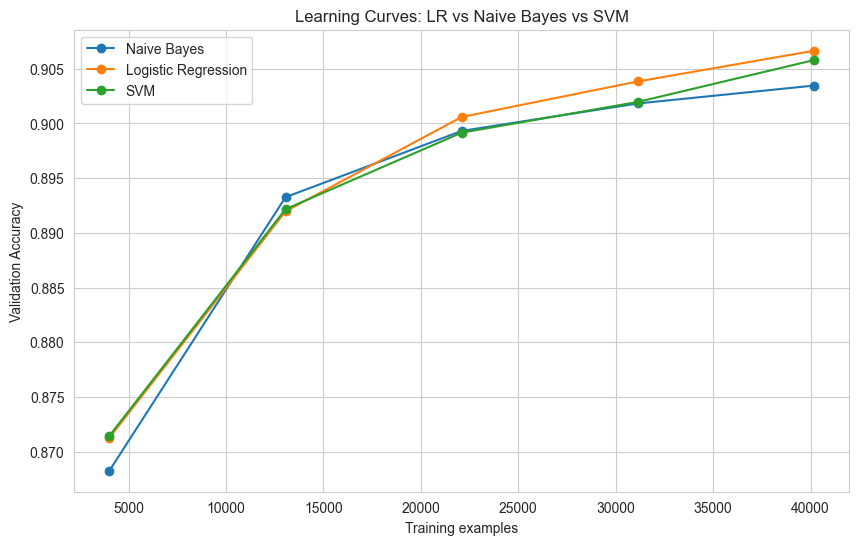

In [37]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(max_iter=1000)
}

plt.figure(figsize=(10, 6))

for name, clf in models.items():
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', clf)
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        model, train_x, train_y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    val_mean = val_scores.mean(axis=1)
    plt.plot(train_sizes, val_mean, marker='o', label=name)

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curves: LR vs Naive Bayes vs SVM")
plt.legend()
plt.grid(True)
plt.show()

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent wi

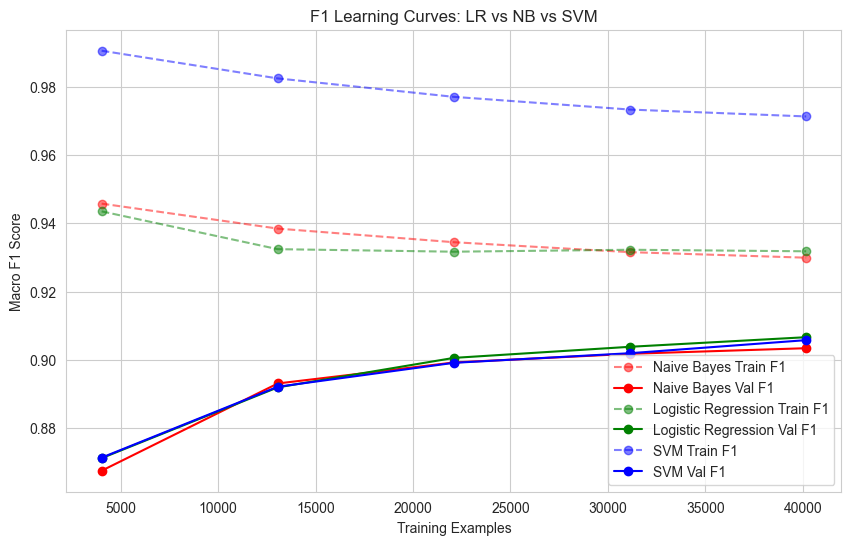

In [38]:
# F1 scores curve
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(max_iter=1000)
}
colors = {
    "Naive Bayes": "red",
    "Logistic Regression": "green",
    "SVM": "blue"
}
plt.figure(figsize=(10, 6))
for name, clf in models.items():
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', clf)
    ])

    train_sizes, train_scores, val_scores = learning_curve(
        model, train_x, train_y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    c = colors[name]
    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{name} Train F1")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{name} Val F1")

plt.xlabel("Training Examples")
plt.ylabel("Macro F1 Score")
plt.title("F1 Learning Curves: LR vs NB vs SVM")
plt.legend()
plt.grid(True)
plt.savefig("Ch_F1_LearningCurves.pdf", bbox_inches='tight')
plt.show()

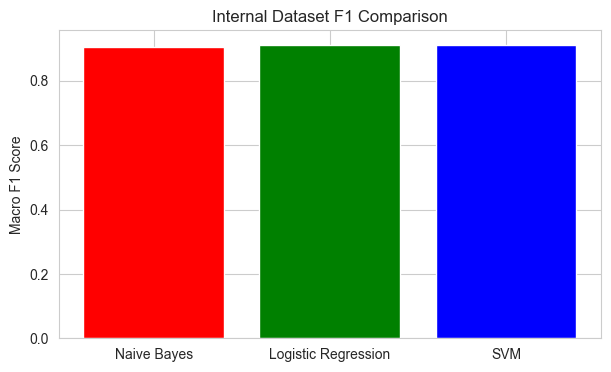

In [39]:
models = {
    "Naive Bayes": nb_pred,
    "Logistic Regression": lr_pred,
    "SVM": svm_pred
}

f1_scores = []

for name, pred in models.items():
    score = f1_score(test_y, pred, average='macro')
    f1_scores.append(score)

plt.figure(figsize=(7,4))
plt.bar(models.keys(), f1_scores, color=['red','green','blue'])
plt.ylabel("Macro F1 Score")
plt.title("Internal Dataset F1 Comparison")
plt.show()

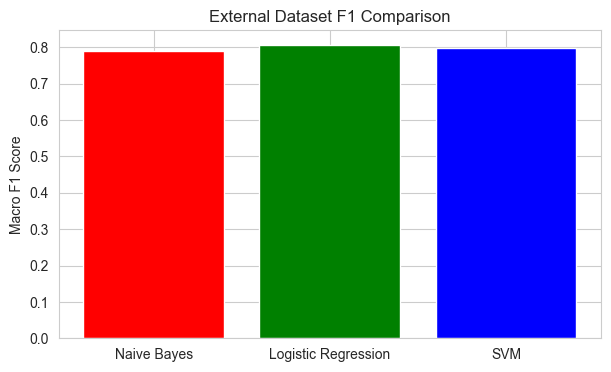

In [40]:
models = {
    "Naive Bayes": external_nb_pred,
    "Logistic Regression": external_lr_pred,
    "SVM": external_svm_pred
}

f1_scores = []

for name, pred in models.items():
    score = f1_score(external_test_y, pred, average='macro')
    f1_scores.append(score)

plt.figure(figsize=(7,4))
plt.bar(models.keys(), f1_scores, color=['red','green','blue'])
plt.ylabel("Macro F1 Score")
plt.title("External Dataset F1 Comparison")
plt.show()

In [41]:
print(classification_report(test_y, nb_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6197
           1       0.90      0.91      0.91      6358

    accuracy                           0.91     12555
   macro avg       0.91      0.91      0.91     12555
weighted avg       0.91      0.91      0.91     12555



In [42]:
print(classification_report(test_y, lr_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      6197
           1       0.92      0.90      0.91      6358

    accuracy                           0.91     12555
   macro avg       0.91      0.91      0.91     12555
weighted avg       0.91      0.91      0.91     12555



In [43]:
print(classification_report(test_y, svm_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6197
           1       0.91      0.91      0.91      6358

    accuracy                           0.91     12555
   macro avg       0.91      0.91      0.91     12555
weighted avg       0.91      0.91      0.91     12555



In [55]:
subset_sizes = [0.001, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ])

    nb_model.fit(X_sub, y_sub)
    nb_sub_pred = nb_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("NB Accuracy: ", accuracy_score(nb_sub_pred, y_sub_test))

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.001
NB Accuracy:  0.5360389092648701


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.2
NB Accuracy:  0.889085252022402


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.5
NB Accuracy:  0.8979250467959696


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/skl

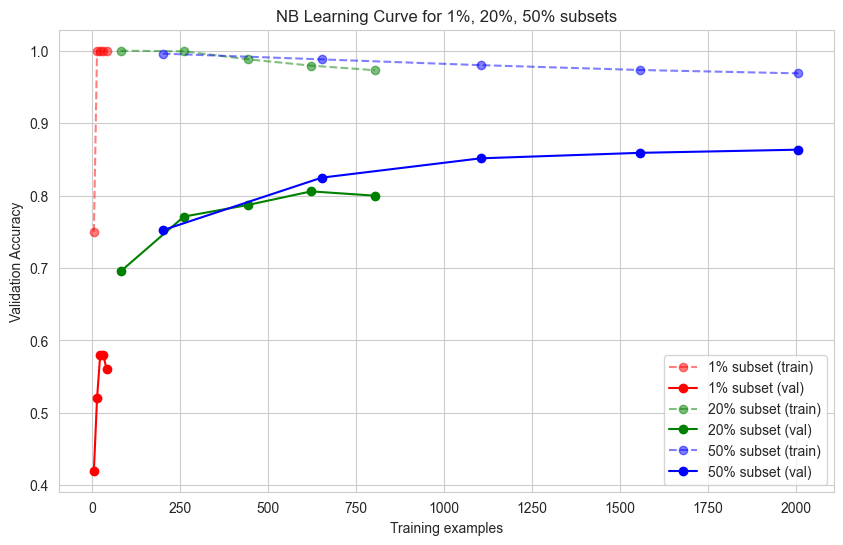

In [74]:
# divide training set to 10%,20%,50%
subset_sizes = [0.001, 0.02, 0.05]
sub_labels = ["1% subset", "20% subset", "50% subset"]
colors = ["red", "green", "blue"]

plt.figure(figsize=(10, 6))

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, _, y_sub, _ = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ])

    # learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_sub, y_sub,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5,
        n_jobs=-1
    )

    # create validation curve
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.plot(train_sizes, train_mean, '--', marker='o', color=c, alpha=0.5, label=f"{label} (train)")
    plt.plot(train_sizes, val_mean, '-', marker='o', color=c, label=f"{label} (val)")

plt.xlabel("Training examples")
plt.ylabel("Validation Accuracy")
plt.title("NB Learning Curve for 1%, 20%, 50% subsets")
plt.legend()
plt.grid(True)
plt.savefig("Ch_NB_LearningCurves.pdf", bbox_inches='tight')
plt.show()

In [45]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    lr_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    lr_model.fit(X_sub, y_sub)
    lr_sub_pred = lr_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("LR Accuracy: ", accuracy_score(lr_sub_pred, y_sub_test))

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.1
LR Accuracy:  0.8775582450162621


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.2
LR Accuracy:  0.8889359054138145


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.5
LR Accuracy:  0.900792544505954


In [79]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        train_x, train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    svm_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', LinearSVC(max_iter=1000))
    ])

    svm_model.fit(X_sub, y_sub)
    svm_sub_pred = svm_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("SVM Accuracy: ", accuracy_score(svm_sub_pred, y_sub_test))

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.1
SVM Accuracy:  0.8805894196517468


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.2
SVM Accuracy:  0.8892843808338519


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.



Subset scale: 0.5
SVM Accuracy:  0.8986419212234656


In [47]:
sub_train_x, sub_test_x, sub_train_y, sub_test_y = model_selection.train_test_split(extra_test_x, extra_test_y, train_size = 0.80, shuffle = True, random_state = 42)

In [78]:
subset_sizes = [0.1, 0.2, 0.8]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        sub_train_x, sub_train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    nb_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ])

    nb_model.fit(X_sub, y_sub)
    nb_sub_pred = nb_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("NB Accuracy: ", accuracy_score(nb_sub_pred, y_sub_test))

Subset scale: 0.1
NB Accuracy:  0.5569620253164557
Subset scale: 0.2
NB Accuracy:  0.75
Subset scale: 0.8
NB Accuracy:  0.8857142857142857


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

In [49]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        sub_train_x, sub_train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    svm_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', LinearSVC(max_iter=1000))
    ])

    svm_model.fit(X_sub, y_sub)
    svm_sub_pred = svm_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("SVM Accuracy: ", accuracy_score(svm_sub_pred, y_sub_test))

Subset scale: 0.1
SVM Accuracy:  0.5569620253164557
Subset scale: 0.2
SVM Accuracy:  0.7142857142857143
Subset scale: 0.5
SVM Accuracy:  0.875


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w

In [50]:
subset_sizes = [0.1, 0.2, 0.5]
sub_labels = ["10% subset", "20% subset", "50% subset"]

for size, label, c in zip(subset_sizes, sub_labels, colors):
    # extract training subsets
    # The Hitchhiker’s Guide to the Galaxy!
    X_sub, X_sub_test, y_sub, y_sub_test = train_test_split(
        sub_train_x, sub_train_y, train_size=size, random_state=42, shuffle=True
    )

    # establish pipeline
    lr_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=jieba_tokenizer, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    lr_model.fit(X_sub, y_sub)
    lr_sub_pred = lr_model.predict(X_sub_test)

    print("Subset scale:", size)
    print("SVM Accuracy: ", accuracy_score(lr_sub_pred, y_sub_test))

Subset scale: 0.1
SVM Accuracy:  0.5063291139240507
Subset scale: 0.2
SVM Accuracy:  0.7214285714285714
Subset scale: 0.5
SVM Accuracy:  0.7954545454545454


/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['傥', '兼', '前', '唷', '啪', '啷', '喔', '天', '始', '漫', '然', '特', '竟', '莫', '见', '设', '说', '达', '非'] not in stop_words.

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/xanderquinn/Projects/ScientificWriting/myenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop w